<a id='exploratory-analysis-of-the-rrst-pressure-and-flow-project'></a>

## <mark style="background-color: #FFC300"> Exploratory analysis for the RRST pressure and flow project </mark>

#### Table of contents:

1. [Description of the data](#Description-of-the-data)
1. [Getting Photodiode and Respiration data](#Getting-Photodiode-and-Respiration-data)
1. [Filtering Photodiode data](#Filtering-Photodiode-data)
1. [Demeaning and finding negative values in the signal for later processing](#Demeaning-and-finding-negative-values-in-the-signal-for-later-processing)
1. [Clustering the tutorial and stimulus periods](#Clustering-the-tutorial-and-stimulus-periods)
1. [Obtaining the photodiode trigger points](#Obtaining-the-photodiode-trigger-points)
1. [Correcting the position of the negative values after substracting the tutorial period](#Correcting-the-position-of-the-negative-values-after-substracting-the-tutorial-period)
1. [Select valid stimuli periods](#Select-valid-stimuli-periods)
1. [For each valid trial: store stimulus, response, behavioural data and match](#For-each-valid-trial:-store-stimulus,-response,-behavioural-data-and-match)
1. [Respiration data](#Respiration-data)
1. [Import Pressure data](#Import-Pressure-data)
1. [Import Flow data](#Import-Flow-data)
1. [Aligning flow and pressure data with the behavioral data](#Aligning-flow-and-pressure-data-with-the-behavioral-data)



<a id='Description-of-the-data'></a>

#### <mark style="background-color: #DAF7A6"> **Description of the data:** </mark>

INPUT:
The data is in a folder called "sub_{identificationNumber}", inside of a folder called "subjects", inside of a folder called "data".

Each sensor data is stored with different formats. The sensors and formats are:
* respiration belt + photodiode -> .tsv.gz (comes with a .json file that describes the columns)
* flow -> .edf      <mark style="background-color: #FFFF00">note that before it was PRESSURE !!!!</mark>
* pressure -> .csv      <mark style="background-color: #FFFF00">note that before it was FLOW !!!!</mark>

In addition:
* behavioural data is stored in .tsv
The behavioural data file does NOT contain information about the tutorial period. It contains information about which stimulus (1st or 2nd) contains the signal and if the decision of the participant was right or wrong (0 or 1). It also contains information about the time (from the beginning of the experiment) when the stimulus was presented, the decision of the subject, how long it took to respond, confidence rate, time to rate confidence.

PROCESSING:

We will use the triggers from the photodiode to get the signal from the sensors. The tutorials start at slightly different times but the two stimuli start at the same time interval one after the other. The output recordings of interest are two for each sensor. 

Some subjects do not have all files. The subject should be excluded if any of them do not have the pressure or the flow data, or if it is not possible to know when the data was recorded with respect to the start of the stimulus. The data that is not essential is that from the respiration belt.

To synchronize the data from the behavioural file with the respiration belt recordings the best option is to use the photodiode information. It may also be possible to use the timing information in the behavioural file.

To align/synchronize the data from the flow sensor, the pressure sensor and the behavioural data, we will attempt several analysis techniques.

OUTPUT:
The output of the processing script will be generated in a newly created dictionary file called "sub_{identificationNumber}.json", inside of a newly created folder called "results", inside of the folder called "data".

Inside the json file called "sub_{identificationNumber}.json" in the results folder there will be the following information:

* trial number:
    * stim1 respiration array (may be NaN)
    * stim1 flow array
    * stim1 pressure array
    * stim2 respiration array (may be NaN)
    * stim2 flow array
    * stim2 pressure array
    * photodiode information:
        * 2x stimulus short pulses: phot_stim1, phot_stim2 = 'up'/'down'. A pulse UP contains the signal, the other pulse will be down.
            * so: if the 1st stimulus is UP, stim1 contains the signal.
            * if the 2nd -> UP, then it is stim2.
        * 1x decision longer pulse: phot_response: 'up'/'down'
            * up = 1st stimulus was thought (by the participant) to contain the signal, 
            * down = 2nd stimulus
    * behavioural information:
        * beh_signal_interval (1 or 2) -> 1st or 2nd stimulus contains the signal.
        * beh_decision (0 or 1) -> 1st or 2nd.
        * beh_correct (1 or 0) -> right or wrong.
        * beh_stimulus level.
    * match: does the photodiode pulses match the behavioural data (1 or 0) -> yes or no.



In [125]:
import pandas as pd
import matplotlib.pyplot as plt
# import neurokit2 as nk
import platform
import glob
import json
import numpy as np
from scipy.signal import butter, lfilter, freqz, find_peaks
from pathlib import Path
import csv

from tkinter import Tk
from tkinter.filedialog import askdirectory
import re
from scipy import signal

In [126]:
my_system = platform.uname()
print(my_system.node)

isUpdatePlots = 1

if my_system.node == "DESKTOP-JNG9AD3":

    goodSubject = 0

    if goodSubject:
        subject = "0295"
        absolute_path = 'C:/Users/Alberto/Desktop/github/alignment-temporal-series/data/subjects/sub_' + subject + '/'    
    else:
        subject = "0272"
        absolute_path = 'C:/Users/Alberto/Desktop/github/alignment-temporal-series/data/badExamples/sub_' + subject + '/'    
 

elif my_system.node == "d39979":
    print("write the absolute path to the folder in data_dir")
    data_dir = './example_data_sub-0597/'
    filename = 'sub-0597_ses-session1_task-rrst_physio.tsv.gz'

DESKTOP-JNG9AD3


<a id='Getting-Photodiode-and-Respiration-data'></a>

#### <mark style="background-color: #DAF7A6"> **Getting Photodiode and Respiration data:** </mark>

Data stored in a .tsv.gz file.

Description stored in json format with the same file name.

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [127]:
# getting photodiode and respiration belt data
path_file = absolute_path + '*.tsv.gz'
files = glob.glob(path_file)

data = pd.read_csv(files[0], compression='gzip', sep='\t')
data.head()

,Stim,Respiration,ECG
0,44484,32225,-0.154907
1,48568,32220,-0.150421
2,45984,32228,-0.148315
3,48032,32216,-0.148315
4,47936,32189,-0.147766


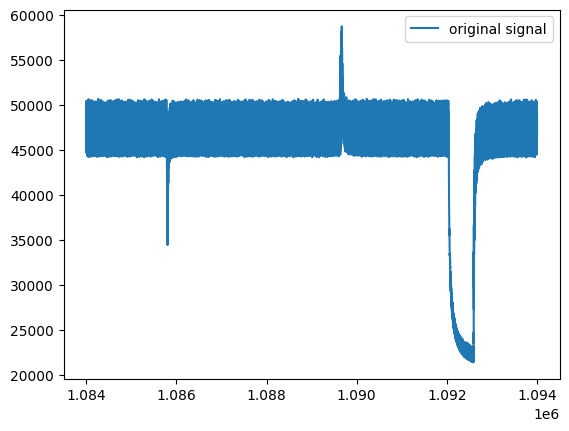

{'SamplingFrequency': 1000,
 'StartTime': 0.0,
 'Columns': ['ECG', 'Respiration', 'Stim'],
 'cardiac': {'Units': 'mV'}}

In [128]:
# getting data description

# path and name minus extension:
path_name_minus_extension = files[0][:-7]
 
# Opening JSON file
f = open(path_name_minus_extension + '.json')

# returns JSON object as 
# a dictionary
meta_data = json.load(f)
f.close()

photo_diode_data = data['Stim']

if isUpdatePlots:
    # Example data
    range_start = 1084000
    range_end = 1094000

    # %matplotlib tk
    %matplotlib inline
    plt.plot(photo_diode_data[range_start:range_end], label='original signal')
    plt.legend()
    plt.show()

meta_data

<a id='Filtering-Photodiode-data'></a>

#### <mark style="background-color: #DAF7A6"> **Filtering Photodiode data:** </mark>

The photodiode data could be noisy (example: subject 0295).

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [129]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 1
fs = meta_data['SamplingFrequency']       # sample rate, Hz
cutoff = 10                          # desired cutoff frequency of the filter, Hz
T = len(photo_diode_data)/fs
n = int(T * fs) # total number of samples

t = np.linspace(0, T, n, endpoint=False)

# Filter the data, and plot both the original and filtered signals.
photo_diode_data_filtered = butter_lowpass_filter(photo_diode_data, cutoff, fs, order)



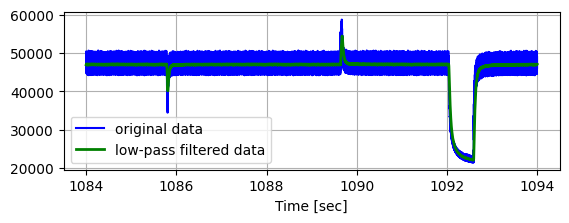

In [130]:
%matplotlib inline

if isUpdatePlots:
    
    # to visualize the effect of the filter

    plt.subplot(2, 1, 2)
    plt.plot(t[range_start:range_end], photo_diode_data[range_start:range_end], 'b-', label='original data')
    plt.plot(t[range_start:range_end], photo_diode_data_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

<a id='Demeaning-and-finding-negative-values-in-the-signal-for-later-processing'></a>

#### <mark style="background-color: #DAF7A6"> **Demeaning and finding negative values in the signal for later processing:** </mark>

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [131]:
# Extracting mean and reversing down signals in the photodiode data
# Keeping where are the values that are negative to reverse the signal later
%matplotlib inline
data_dm = photo_diode_data_filtered - np.mean(photo_diode_data_filtered)
data_dm_rev = np.abs(data_dm)
where_neg_signal = np.where(data_dm < 0)


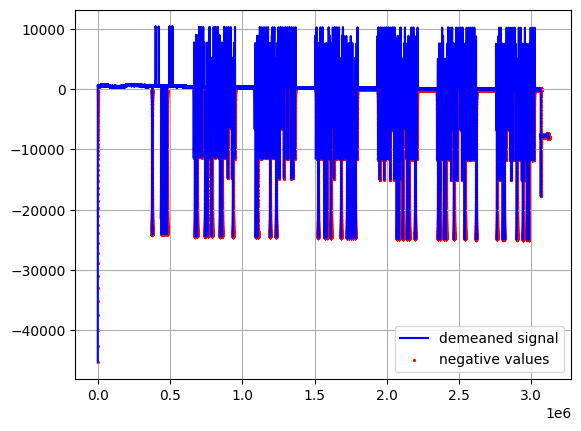

In [132]:
# Visualizing the signal demeaned and the negative values of the signal.
if isUpdatePlots:
    
    plt.plot(data_dm, 'b-', label='demeaned signal')
    plt.scatter(where_neg_signal, data_dm[where_neg_signal], s=1.7, c='r', label='negative values')

    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

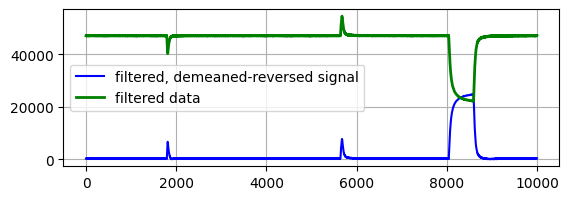

In [133]:
# Visualizing the resuls of demeaning and reversing the signal
if isUpdatePlots:
    
    plt.subplot(2, 1, 1)
    plt.plot(data_dm_rev[range_start:range_end], 'b-', label='filtered, demeaned-reversed signal')
    plt.plot(photo_diode_data_filtered[range_start:range_end], 'g-', linewidth=2, label='filtered data')
    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

<a id='Clustering-the-tutorial-and-stimulus-periods'></a>

#### <mark style="background-color: #DAF7A6"> **Clustering the tutorial and stimulus periods:** </mark>

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [134]:
# Clustering the points in the signal to differentiate between tutorial and stimulus periods
# the objective is to discard the tutorial period.
from sklearn.cluster import KMeans

xArray = np.linspace(1,len(data_dm_rev),len(data_dm_rev))
signalAsPoints =  np.column_stack((xArray, data_dm_rev))

kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(signalAsPoints)

y_kmeans = kmeans.predict(signalAsPoints)
centers = kmeans.cluster_centers_


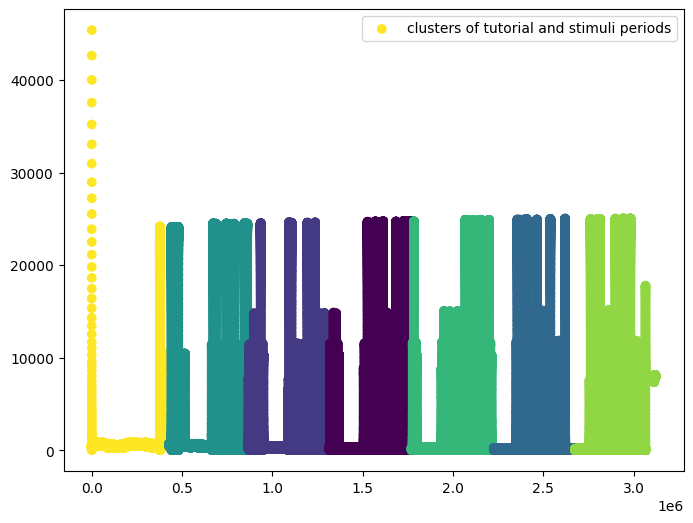

In [135]:
# # Visualize clusters in different colours
if isUpdatePlots:
    
    plt.figure(figsize=(8, 6))
    plt.scatter(signalAsPoints[:,0], signalAsPoints[:,1], c=kmeans.labels_.astype(float), label='clusters of tutorial and stimuli periods')
    plt.legend()
    plt.show()

C:\Users\Alberto\AppData\Local\Temp\ipykernel_27872\794796479.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(signalAsPoints[y_kmeans==6, 0], signalAsPoints[y_kmeans==6, 1], s=50, cmap='viridis', label='tutorial period to discard')


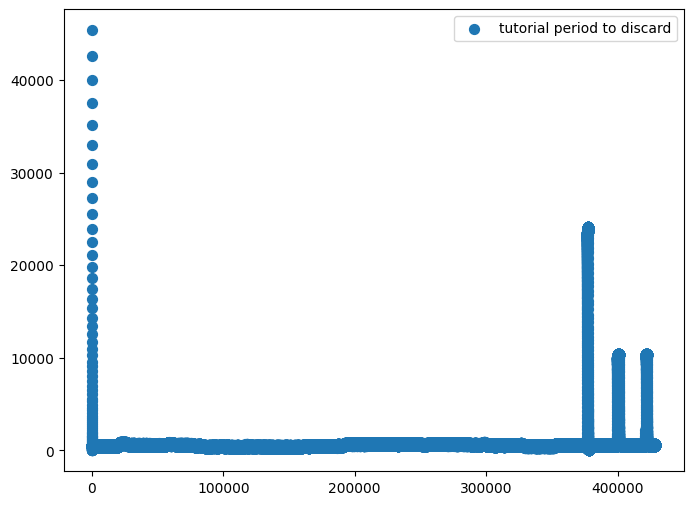

In [136]:
# visualizing the tutorial period to discard

if isUpdatePlots:

    plt.figure(figsize=(8, 6))
    plt.scatter(signalAsPoints[y_kmeans==6, 0], signalAsPoints[y_kmeans==6, 1], s=50, cmap='viridis', label='tutorial period to discard')
    plt.legend()
    plt.show()

In [137]:
# Selecting stimuli periods

findClustrers = np.where(y_kmeans < 6)[0]
signalWithouttutorial = signalAsPoints[findClustrers, :]
kmeansNotutorial = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(signalWithouttutorial)
y_kmeansNotutorial = kmeansNotutorial.predict(signalWithouttutorial)

# Stimuli periods normalized
signal_1D = signalWithouttutorial[:,1]
signal_1D_norm = (signal_1D - np.min(signal_1D)) / np.max(signal_1D - np.min(signal_1D))


<a id='Obtaining-the-photodiode-trigger-points'></a>

#### <mark style="background-color: #DAF7A6"> **Obtaining the photodiode trigger points:** </mark>

It is known the duration of short and long signals from the examples saved as "short_signal.npy" and "long_signal.npy".

A threshold of 0.15 will be chosen to determine where is the signal.

Only the ascending part of the signal will be saved for further analysis.

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [138]:
# Function to obtain points. 
#  For visualizing the debuggin process

def scatterPointsXY_inSignalInterval(visStart,visEnd,subsetOfPoints,visualize=False,long_signal=np.array([])):
    ''' Function to obtain the points within an interval 
    to scatter on top of the same signal interval in a plot.
    Such points come from a subset of points after some calculation like points above a threshold 

     - Example of use:

        # a very long signal:
        long_signal = np.random.normal(scale=1, size=int(1e04))

        # select some interval within the signal
        visStart = 5000
        visEnd = 5100

        # some condition that selects a subset of points in the long signal
        subsetOfPoints = np.array(np.where(long_signal > 0.5))

        vis_X, vis_Y = scatterPointsXY_inSignalInterval(visStart,visEnd,subsetOfPoints)

        plt.figure(figsize=(10, 4.5))
        ax = plt.subplot(2,1,1)
        ax.plot(long_signal[:visStart], color='b')
        ax.plot(range(visStart-1,visEnd),long_signal[visStart-1:visEnd], color='r',label='interval of interest')
        ax.plot(range(visEnd-1,len(long_signal)),long_signal[visEnd-1:], color='b',label='original signal')
        ax.legend()
        plt.subplot(2,1,2)
        plt.plot(long_signal[visStart:visEnd],label='interval within the original signal')
        plt.scatter(vis_X, long_signal[vis_Y],c='r',label='subset of points within the interval that satisfy some condition')
        plt.xticks([0,visEnd-visStart],[visStart,visEnd])
        plt.legend()
        plt.show()

    dependencies: numpy, matplotlib
    '''
    points_aboveStart = np.array(subsetOfPoints)[np.where(visStart<subsetOfPoints)]
    vis_Y = np.array(points_aboveStart)[np.where(visEnd>points_aboveStart)]
    vis_X = np.array(points_aboveStart)[np.where(visEnd>points_aboveStart)] - visStart

    if visualize:
        if long_signal.size == 0:
            print("Input the original signal to visualize interval and the points...")
        else:
            if visStart == 0:
                visStart = 1
            plt.figure(figsize=(10, 4.5))
            ax = plt.subplot(2,1,1)
            ax.plot(long_signal[:visStart], color='b')
            ax.plot(range(visStart-1,visEnd),long_signal[visStart-1:visEnd], color='r',label='interval of interest')
            ax.plot(range(visEnd-1,len(long_signal)),long_signal[visEnd-1:], color='b',label='original signal')
            ax.legend()
            plt.subplot(2,1,2)
            plt.plot(long_signal[visStart:visEnd],label='interval within the original signal')
            plt.scatter(vis_X, long_signal[vis_Y],c='r',label='subset of points within the interval that satisfy some condition')
            plt.xticks([0,visEnd-visStart],[visStart,visEnd])
            plt.legend()
            plt.show()

    return vis_X, vis_Y

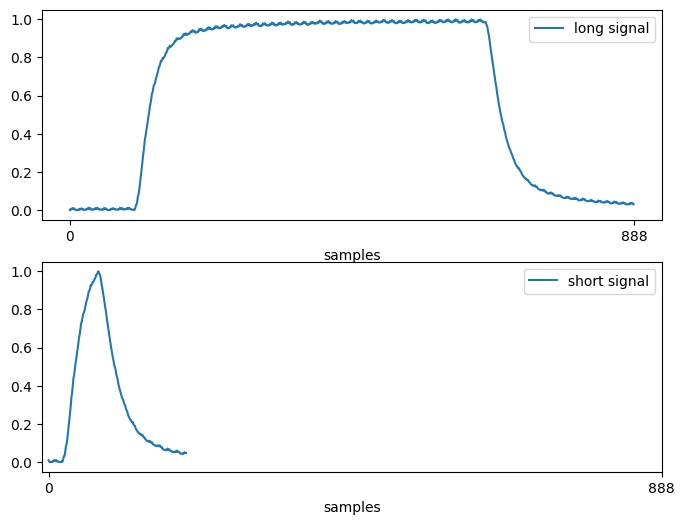

In [139]:
# loading and visualizing long and short signals

long_signal = np.load("long_signal.npy")
short_signal = np.load("short_signal.npy")

if isUpdatePlots:
    
    plt.figure(figsize=(8, 6))
    plt.subplot(2,1,1)
    plt.plot(long_signal,label='long signal')
    plt.xlabel('samples')
    plt.xticks([0,len(long_signal)])
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(short_signal,label='short signal')
    plt.xlabel('samples')
    plt.xticks([0,len(long_signal)])
    plt.legend()
    plt.show()

In [140]:
# obtaining the signal width for a threshold value of 0.15

short_signal_GreaterThan015 = np.where(short_signal > 0.15)
short_signal_width = short_signal_GreaterThan015[0][-1] - short_signal_GreaterThan015[0][0]
short_signal_width = int(short_signal_width - 0.2*short_signal_width)

print('short signal width - 20%: ' + str(short_signal_width))

long_signal_GreaterThan015 = np.where(long_signal > 0.15)
long_signal_width = long_signal_GreaterThan015[0][-1] - long_signal_GreaterThan015[0][0]
long_signal_width = int(long_signal_width - 0.2*long_signal_width)

print('long signal width - 20%: '+str(long_signal_width))

short signal width - 20%: 82
long signal width - 20%: 488


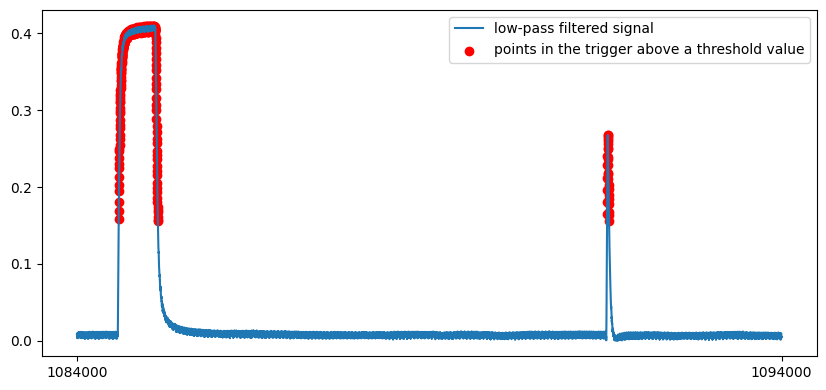

In [141]:
# obtaining position of all the triggers in the signal for a threshold value of 0.15

triggers = np.array(np.where(signal_1D_norm > 0.15))

# Visualizing the signal and the trigger points above the threshold
#  - and only the first point in the ascending part of the trigger 
%matplotlib inline

if isUpdatePlots:
    
    visStart = range_start
    visEnd = range_end

    triggers_vis_X, triggers_vis_Y = scatterPointsXY_inSignalInterval(visStart,visEnd,triggers)

    plt.figure(figsize=(10, 4.5))
    plt.plot(signal_1D_norm[visStart:visEnd],label='low-pass filtered signal')
    plt.scatter(triggers_vis_X, signal_1D_norm[triggers_vis_Y],c='r',label='points in the trigger above a threshold value')
    plt.xticks([0,visEnd-visStart],[visStart,visEnd])
    plt.legend()
    plt.show()

In [142]:
# Function to determine where the trigger starts and if it is short or long

def getPositionTrigger(triggers_diff, long_signal_width):
    ''' Function to determine where the trigger starts and if it is short or long
    It uses the difference between the points inside of the trigger signal 'triggers_diff'
    and the width of the long signal
    '''
    shortORlong_Trigger = np.array([])
    countTriggerWidth = 0
    countIter = 0
    positionTriggers = np.array([])
    positionTriggers = np.append(positionTriggers,countIter)
    inTrigger = 1
    for iterTrigger in triggers_diff:
        countIter += 1
        if inTrigger:
            countTriggerWidth += 1
            if iterTrigger != 1:
                inTrigger = 0
                if countTriggerWidth > long_signal_width:
                    shortORlong_Trigger = np.append(shortORlong_Trigger,2)
                else:
                    shortORlong_Trigger = np.append(shortORlong_Trigger,1)
                countTriggerWidth = 0
        else:           
            if iterTrigger == 1:
                inTrigger = 1
                positionTriggers = np.append(positionTriggers,countIter)
    positionTriggers = positionTriggers.astype(int)
    shortORlong_Trigger = shortORlong_Trigger.astype(int)
    return positionTriggers, shortORlong_Trigger

In [143]:
triggers = np.array(np.where(signal_1D_norm > 0.15))
triggers_diff = triggers[0][1:] - triggers[0][:-1]
positionTriggers, shortORlong_Trigger = getPositionTrigger(triggers_diff, long_signal_width)
find_ShortSignals = np.where(shortORlong_Trigger == 1)
find_LongSignals = np.where(shortORlong_Trigger == 2)

position_beginningTrigger_short = triggers[0][positionTriggers[find_ShortSignals]]
position_beginningTrigger_long = triggers[0][positionTriggers[find_LongSignals]]

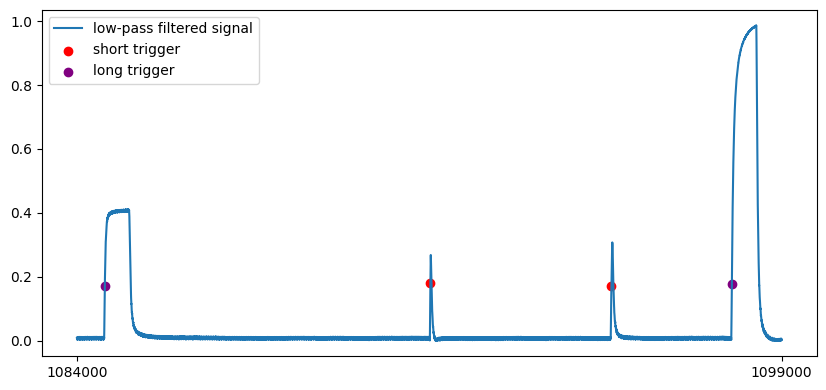

In [144]:
# Visualizing the start of the triggers and if they are short or long

if isUpdatePlots:
    
    visStart = range_start
    visEnd = visStart + 15000

    triggers_vis_X_short, triggers_vis_Y_short = scatterPointsXY_inSignalInterval(visStart,visEnd,position_beginningTrigger_short)

    triggers_vis_X_long, triggers_vis_Y_long = scatterPointsXY_inSignalInterval(visStart,visEnd,position_beginningTrigger_long)

    %matplotlib inline

    plt.figure(figsize=(10, 4.5))
    plt.plot(signal_1D_norm[visStart:visEnd], label='low-pass filtered signal')
    plt.scatter(triggers_vis_X_short, signal_1D_norm[triggers_vis_Y_short],c='r',label='short trigger')
    plt.scatter(triggers_vis_X_long, signal_1D_norm[triggers_vis_Y_long],c='purple',label='long trigger')
    plt.xticks([0,visEnd-visStart],[visStart,visEnd])
    plt.legend()
    plt.show()




In [145]:
# Refining the location of the trigger points. 
#  For each trigger point, we look at a window of 25 samples before the trigger point.
#  The location is the first minimum point 

def findMinPositionTrigger(posTrigger, signal, windowSize):
    newPositions = np.ndarray([])
    for iTriggers in posTrigger:
        chunkBeforeTrigger = np.flipud(signal[iTriggers-windowSize:iTriggers])
        for iChunk in range(0,len(chunkBeforeTrigger)-1):
            if chunkBeforeTrigger[iChunk] <= chunkBeforeTrigger[iChunk+1]:
                newIdx = iChunk + 1
                break
        position = int(iTriggers - newIdx)
        if position < 1:
            position = 0
        newPositions = np.append(newPositions, position)
    return newPositions.astype(int)


In [146]:
windowSize = 25
newPositions_short = findMinPositionTrigger(position_beginningTrigger_short, signal_1D_norm, windowSize)
newPositions_long = findMinPositionTrigger(position_beginningTrigger_long, signal_1D_norm, windowSize)


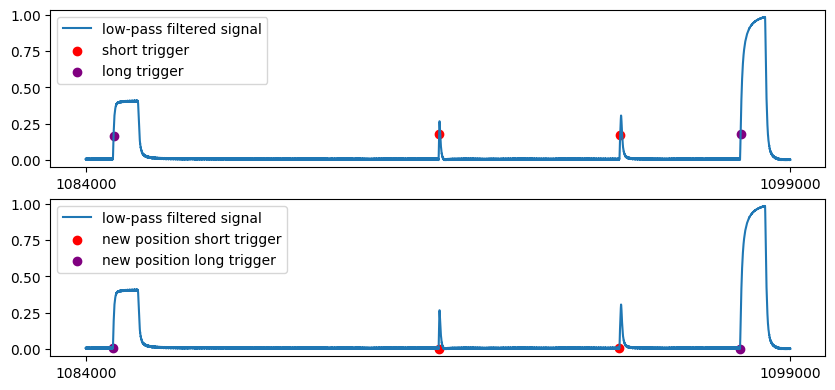

In [147]:
# Visualizing the new position of the triggers

if isUpdatePlots:

    visStart = range_start
    visEnd = visStart + 15000

    newPos_vis_X_long, newPos_vis_Y_long = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_long)
    newPos_vis_X_short, newPos_vis_Y_short = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_short)

    %matplotlib inline

    plt.figure(figsize=(10, 4.5))
    plt.subplot(2,1,1)
    plt.plot(signal_1D_norm[visStart:visEnd], label='low-pass filtered signal')
    plt.scatter(triggers_vis_X_short, signal_1D_norm[triggers_vis_Y_short],c='r',label='short trigger')
    plt.scatter(triggers_vis_X_long, signal_1D_norm[triggers_vis_Y_long],c='purple',label='long trigger')
    plt.xticks([0,visEnd-visStart],[visStart,visEnd])
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(signal_1D_norm[visStart:visEnd], label='low-pass filtered signal')
    plt.scatter(newPos_vis_X_short, signal_1D_norm[newPos_vis_Y_short],c='r',label='new position short trigger')
    plt.scatter(newPos_vis_X_long, signal_1D_norm[newPos_vis_Y_long],c='purple',label='new position long trigger')
    plt.xticks([0,visEnd-visStart],[visStart,visEnd])
    plt.legend()
    plt.show()

<a id='Correcting-the-position-of-the-negative-values-after-substracting-the-tutorial-period'></a>

#### <mark style="background-color: #DAF7A6"> **Correcting the position of the negative values after substracting the tutorial period:** </mark>

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [148]:
# Obtaining the length of the tutorial signal

tutorialPoints = np.where(y_kmeans == 6)[0]
where_neg_signal_notutorial = np.array(where_neg_signal) - len(tutorialPoints)
neg_signal = np.array(where_neg_signal_notutorial[0])[np.where(np.array(where_neg_signal_notutorial[0])>=0)]

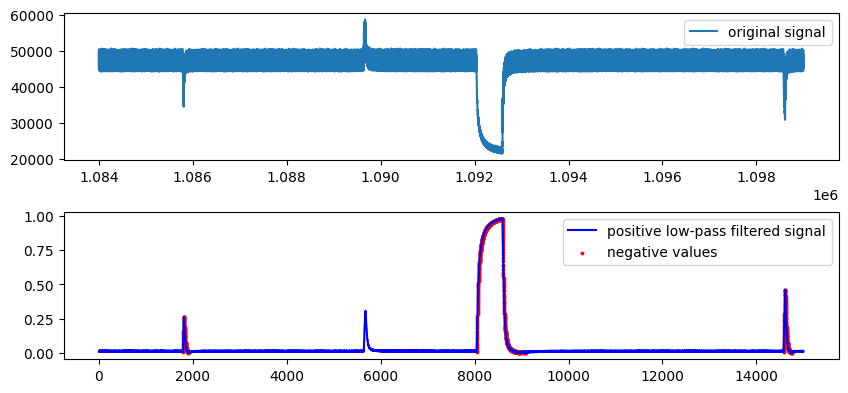

In [149]:
# Visualizing the signal demeaned and the negative values of the signal.

if isUpdatePlots:

    visStartOrg = range_start #486000
    visEndOrg = visStartOrg + 15000 #496000
    visStart = visStartOrg - len(tutorialPoints)
    visEnd = visEndOrg - len(tutorialPoints)

    %matplotlib inline
    plt.figure(figsize=(10, 4.5))

    plt.subplot(2,1,1)
    plt.plot(photo_diode_data[visStartOrg:visEndOrg], label='original signal')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(signal_1D_norm[visStart:visEnd], 'b-', label='positive low-pass filtered signal')

    aboveStartNeg_signal = np.array(neg_signal)[np.where(visStart<neg_signal)]
    subSignal_neg_Y = np.array(aboveStartNeg_signal)[np.where(visEnd>aboveStartNeg_signal)]
    subSignal_neg_X = np.array(aboveStartNeg_signal)[np.where(visEnd>aboveStartNeg_signal)] - visStart

    negValues_X, negValuesY = scatterPointsXY_inSignalInterval(visStart,visEnd,neg_signal)

    plt.scatter(negValues_X, signal_1D_norm[negValuesY], s=3, c='r', label='negative values')

    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

In [150]:
# Re-reversing the negative values

signal_1D_norm_WithNegVals = np.array(signal_1D_norm)
signal_1D_norm_WithNegVals[neg_signal] = signal_1D_norm_WithNegVals[neg_signal] * -1

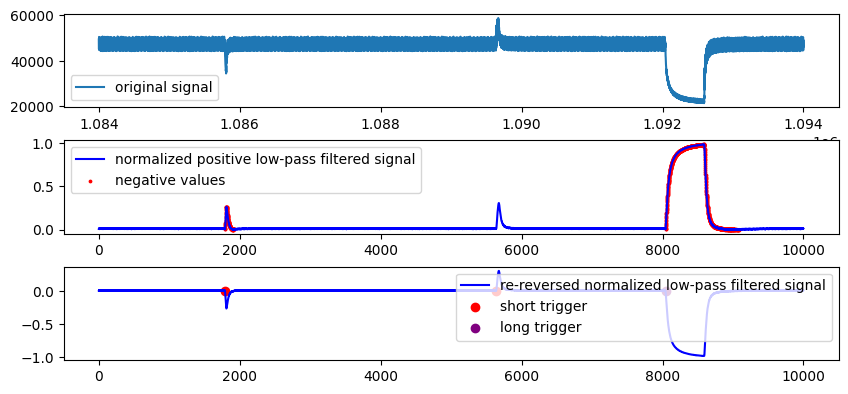

In [151]:
# Visualizing everything together

if isUpdatePlots:

    visStartOrg = range_start #488000
    visEndOrg = range_end #496000
    visStart = visStartOrg - len(tutorialPoints)
    visEnd = visEndOrg - len(tutorialPoints)

    negValues_X, negValuesY = scatterPointsXY_inSignalInterval(visStart,visEnd,neg_signal)

    newTriggers_vis_X_short, newTriggers_vis_Y_short = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_short)
    newTriggers_vis_X_long, newTriggers_vis_Y_long = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_long)


    %matplotlib inline
    plt.figure(figsize=(10, 4.5))

    plt.subplot(3,1,1)
    plt.plot(photo_diode_data[visStartOrg:visEndOrg], label='original signal')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(signal_1D_norm[visStart:visEnd], 'b-', label='normalized positive low-pass filtered signal')
    plt.scatter(negValues_X, signal_1D_norm[negValuesY], s=3, c='r', label='negative values')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(signal_1D_norm_WithNegVals[visStart:visEnd], 'b-', label='re-reversed normalized low-pass filtered signal')
    plt.scatter(newTriggers_vis_X_short, signal_1D_norm_WithNegVals[newTriggers_vis_Y_short],c='r',label='short trigger')
    plt.scatter(newTriggers_vis_X_long, signal_1D_norm_WithNegVals[newTriggers_vis_Y_long],c='purple',label='long trigger')
    plt.legend()
    plt.subplots_adjust(hspace=0.35)
    plt.show()

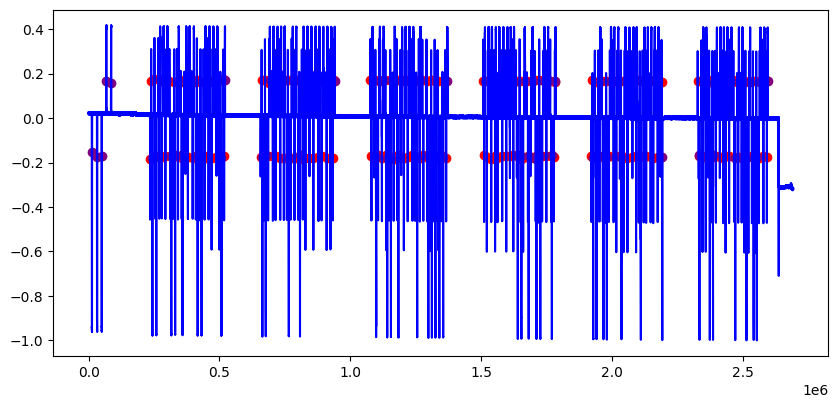

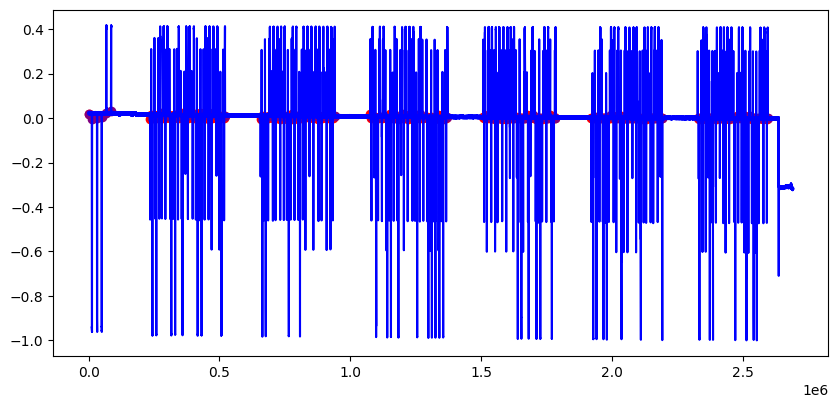

In [152]:
if isUpdatePlots:

    %matplotlib inline

    plt.figure(figsize=(10, 4.5))
    plt.plot(signal_1D_norm_WithNegVals, 'b-', label='re-reversed normalized low-pass filtered signal')
    plt.scatter(position_beginningTrigger_short, signal_1D_norm_WithNegVals[position_beginningTrigger_short],c='r',label='short trigger')
    plt.scatter(position_beginningTrigger_long, signal_1D_norm_WithNegVals[position_beginningTrigger_long],c='purple',label='long trigger')


    plt.figure(figsize=(10, 4.5))
    plt.plot(signal_1D_norm_WithNegVals, 'b-', label='re-reversed normalized low-pass filtered signal')
    plt.scatter(newPositions_short, signal_1D_norm_WithNegVals[newPositions_short],c='r',label='short trigger')
    plt.scatter(newPositions_long, signal_1D_norm_WithNegVals[newPositions_long],c='purple',label='long trigger')



<a id='Select-valid-stimuli-periods'></a>

#### <mark style="background-color: #DAF7A6"> **Select valid stimuli periods:** </mark>

Valid stimuli periods are defined by a sequence of short, short, long trigger signals corresponding to two breathing signals and one response signal.

The algorithm iterates over the long triggers and observes if there are two short triggers within 8000 samples before the long trigger.

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [153]:
def validTriggers(positionShortTriggers, positionLongTriggers, nSamples):
    validTriggersArray = np.ndarray([])
    validShortTriggers = np.ndarray([])
    validLongTriggers = np.ndarray([])
    for iLongTrigger in positionLongTriggers:
        samplesBefore = iLongTrigger - nSamples
        # check how many short triggers there are between the long trigger and nSamples before
        nShortTriggers = np.where(np.logical_and(positionShortTriggers>=samplesBefore, positionShortTriggers<=iLongTrigger))
        whereLongTrigger = np.where(positionLongTriggers == iLongTrigger)
        # if there are 2 short triggers, then store them
        if len(nShortTriggers[0]) == 2:
            validTriggersArray = np.append(validTriggersArray, [positionShortTriggers[nShortTriggers[0][0]], positionShortTriggers[nShortTriggers[0][1]], positionLongTriggers[whereLongTrigger[0][0]]])
            validShortTriggers = np.append(validShortTriggers, [positionShortTriggers[nShortTriggers[0][0]], positionShortTriggers[nShortTriggers[0][1]]])
            validLongTriggers = np.append(validLongTriggers, positionLongTriggers[whereLongTrigger[0][0]])
    # For some reason numpy ndarray creates an extra value in position 0
    validTriggersArray = np.delete(validTriggersArray,0,0)
    validShortTriggers = np.delete(validShortTriggers,0,0)
    validLongTriggers = np.delete(validLongTriggers,0,0)
    return validTriggersArray.astype(int), validShortTriggers.astype(int), validLongTriggers.astype(int)


In [154]:
# valid triggers contain 2 short pulses preceding a long one within a number of samples
nSamples = 12000
validPosTriggers, validShort, validLong = validTriggers(newPositions_short, newPositions_long, nSamples)

# if there are more than 120 validLong triggers, there might be some from the tutorial part
#  that were not excluded during the clustering procedure.
# We are selecting here the last 120 trials

if len(validLong) > 120:
    validLong = validLong[-120:]
    validPosTriggers, validShort, validLong = validTriggers(validShort, validLong, nSamples)

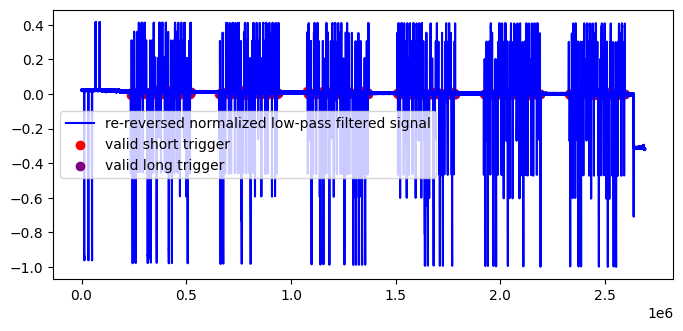

In [155]:
   
if isUpdatePlots:
    
    %matplotlib inline
    plt.figure(figsize=(8, 3.5))
    plt.plot(signal_1D_norm_WithNegVals, 'b-', label='re-reversed normalized low-pass filtered signal')
    plt.scatter(validShort, signal_1D_norm_WithNegVals[validShort],c='r',label='valid short trigger')
    plt.scatter(validLong, signal_1D_norm_WithNegVals[validLong],c='purple',label='valid long trigger')
    plt.legend()
    plt.show()

<a id='For-each-valid-trial:-store-stimulus,-response,-behavioural-data-and-match'></a>

#### <mark style="background-color: #DAF7A6"> **For each valid trial: store stimulus, response, behavioural data and match:** </mark>

Importing the behavioural data in .tsv to check for inconsistencies in the photodiode pulses.

Creating a dictionary to store the values. The format of the dictionary is:

results_dictionary = 

                     { 'trial_number': { 'phot_stim1': 'up'/'down',

                                         'phot_stim2': 'up'/'down',

                                         'phot_response': 'up'/'down',

                                         'beh_signal_interval': 1/2,

                                         'beh_decision': 1/0,

                                         'beh_correct': 1/0,

                                         'beh_stimulus_level': int,

                                         'match': 0/1

                                        }
                                        
                        }

* 1st level keys in the dictionary are the number of the trial -> 'trial_number'.
* 2nd level keys store:
    * for each trial if the stimuli ('phot_stim1', 'phot_stim2') and the 'phot_response' pulses were up or down.
    * the behavioural data corresponding to that trial:
        * 'beh_signal_interval': 1 or 2 representing which stimuli was UP -> containing the signal.
        * 'beh_decision': 0 or 1 if the participant thought it was the 1st or the 2nd stimulus which contained the signal.
        * 'beh_correct': 0 or 1 if the participant responded correctly.
        * 'beh_stimulus_level': integer indicating the stimulus level of the signal in that trial.
* the list 'error' indicates if there is any of the following errors:
    * []: empty list -> no error
    * 1: no match between photodiode stims/response and the behavioural data
    * 2: both short pulses are up or down
    * 3: response pulse indicates that the participant answer correctly but the behavioural data says otherwise.

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [156]:
# Importing behavioural data

path_file = absolute_path + '*.tsv'
files = glob.glob(path_file)
print(files)

behavioural_data = pd.read_csv(files[0], sep='\t')
behavioural_data.head()


['C:/Users/Alberto/Desktop/github/alignment-temporal-series/data/badExamples/sub_0272\\sub-0272_ses-session1_task-rrst_beh.tsv']


,participant_id,id,task,cohort,nTrials,StimulusLevel,SignalInterval,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,ResponseCorrect,EstimatedThreshold,EstimatedSlope,ResponseMade,RatingStart,RatingEnds
0,sub-0272,272,rrst,vmp2,1,9,2,1,2.517343,0.0,1.033361,7.238022,1,16.997194,5201.197004,1,14.275823,15.400789
1,sub-0272,272,rrst,vmp2,2,7,1,1,1.170919,0.0,0.976107,11.065918,0,16.997194,5201.197004,1,29.166382,30.240051
2,sub-0272,272,rrst,vmp2,3,12,1,0,0.926277,0.0,0.936267,10.224687,1,16.997194,5201.197004,1,43.956665,44.987868
3,sub-0272,272,rrst,vmp2,4,10,2,0,0.983616,0.0,0.887068,12.804366,0,16.997194,5201.197004,1,57.756519,58.718833
4,sub-0272,272,rrst,vmp2,5,13,2,0,1.737367,0.0,0.808028,14.735941,0,16.997194,5201.197004,1,71.486991,72.364078


In [157]:
behavioural_subdata = behavioural_data[['SignalInterval','Decision','ResponseCorrect','StimulusLevel','RatingStart']]
behavioural_subdata.head()

,SignalInterval,Decision,ResponseCorrect,StimulusLevel,RatingStart
0,2,1,1,9,14.275823
1,1,1,0,7,29.166382
2,1,0,1,12,43.956665
3,2,0,0,10,57.756519
4,2,0,0,13,71.486991


In [158]:
behavioural_data['SignalInterval'].size

120

In [159]:
# We use the negative signal to spot the down triggers

def resultsDictStimulusResponse(validShort, validLong, neg_signal, behavioural_subdata):
    results = {}

    for iTrial in range(0,len(validLong)):
        phot_stim_interval = 1
        upOrDown_stim1 = 'up'
        upOrDown_stim2 = 'up'
        upOrDown_response = 'up'
        isError = []
        stim1 = validShort[iTrial*2] + 10
        if stim1 in neg_signal:
            upOrDown_stim1 = 'down'
            phot_stim_interval = 2
        stim2 = validShort[iTrial*2+1] + 10
        if stim2 in neg_signal:
            upOrDown_stim2 = 'down'
        response = validLong[iTrial] + 10
        if response in neg_signal:
            upOrDown_response = 'down'
        nTrial = iTrial

        # checking for errors
        if upOrDown_stim1 == 'up':
            # if the stim1 photodiode pulse is up, 
            # the behaviour data should say 1, 
            # so if it is 2 there is a mismatch error.
            if behavioural_subdata.iloc[nTrial]['SignalInterval'] == 2:
                isError.append(1)
        elif upOrDown_stim2 == 'up':
            # the same for the stim2.
            if behavioural_subdata.iloc[nTrial]['SignalInterval'] == 1:
                isError.append(1)
        if upOrDown_response == 'up':
            # if the response photodiode pulse is up, 
            # the behaviour data should say 0, 
            # so if it is 1 there is a mismatch error.
            if behavioural_subdata.iloc[nTrial]['Decision'] == 1:
                isError.append(1)
        if upOrDown_stim1 == upOrDown_stim2:
            isError.append(2)
        if upOrDown_stim1 == 'up':
            # if the 1st stim had the signal, it is 'up'
            # the correct response is also 'up' and
            # the behavioural data decision should say 0 -> 1st stim
            # the behavioural data correct should say 1 -> correct
            if upOrDown_response == 'up':
                if behavioural_subdata.iloc[nTrial]['Decision'] == 0:
                    #  ERRORS are if behavioural ResponseCorrect says 0
                    if behavioural_subdata.iloc[nTrial]['ResponseCorrect'] == 0:
                        isError.append(3)
        if upOrDown_stim2 == 'up':
            # if the 2nd stim had the signal, it is 'up'
            # the correct response is 'down' and
            # the behavioural data decision should say 1 -> 2nd stim
            # the behavioural data correct should say 1 -> correct
            if upOrDown_response == 'down':
                if behavioural_subdata.iloc[nTrial]['Decision'] == 1:
                    #  ERRORS are if behavioural ResponseCorrect says 0
                    if behavioural_subdata.iloc[nTrial]['ResponseCorrect'] == 0:
                        isError.append(3)

        # saving the values inside of the key: 'trial_number' or nTrial
        results[nTrial] = {
                                    'phot_stim1': upOrDown_stim1,
                                    'phot_stim2': upOrDown_stim2,
                                    'phot_response': upOrDown_response,
                                    'phot_stim_interval': phot_stim_interval,
                                    'beh_signal_interval': behavioural_subdata.iloc[nTrial]['SignalInterval'],
                                    'beh_decision': behavioural_subdata.iloc[nTrial]['Decision'],
                                    'beh_correct': behavioural_subdata.iloc[nTrial]['ResponseCorrect'],
                                    'beh_stimulus_level': behavioural_subdata.iloc[nTrial]['StimulusLevel'],
                                    'error': isError
                                }
    return results 




In [160]:
results = resultsDictStimulusResponse(validShort, validLong, neg_signal, behavioural_subdata)

In [161]:
# Check if there are any errors

trials_with_errors = []
for trial in results:
    if results[trial]['error'] != []:
        trials_with_errors.append([trial, results[trial]['error']])
    
print('number of errors found: ', trials_with_errors)

number of errors found:  []


<a id='Respiration-data'></a>

# Getting physiological data

It is stored 0.8s of data after the start of the simulus trigger.

The sample rate is 1000Hz for respiration and flow. 100Hz for Pressure.

#### <mark style="background-color: #DAF7A6"> **Respiration data:** </mark>

Updating the dictionary with the respiration data for each stimulus

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


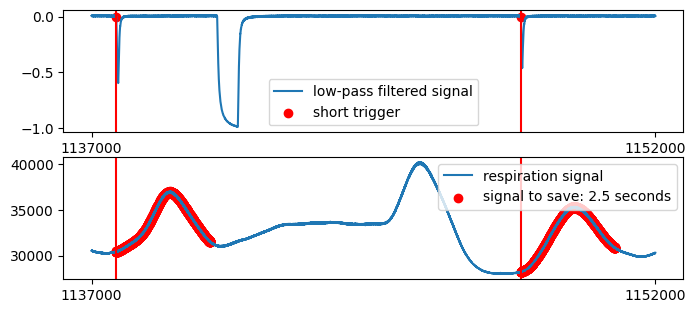

In [257]:
# Visualizing the number of samples that will be stored for a given amount of time after the trigger

secondsToStore = 2.5
nSamples = int(meta_data['SamplingFrequency'] * secondsToStore)

# Getting respiration data
nSamplestutorial = len(tutorialPoints)
RespirationData_origLength = data['Respiration'].to_numpy()
RespirationData = data['Respiration'][nSamplestutorial:].to_numpy()

visStart = 1137000
visEnd = visStart + 15000

newPos_vis_X_long, newPos_vis_Y_long = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_long)
newPos_vis_X_short, newPos_vis_Y_short = scatterPointsXY_inSignalInterval(visStart,visEnd,newPositions_short)

%matplotlib inline

plt.figure(figsize=(8, 3.5))
plt.subplot(2,1,1)
plt.plot(signal_1D_norm_WithNegVals[visStart:visEnd], label='low-pass filtered signal')
plt.scatter(newPos_vis_X_short, signal_1D_norm_WithNegVals[newPos_vis_Y_short],c='r',label='short trigger')
plt.xticks([0,visEnd-visStart],[visStart,visEnd])
for iLine in range(0,len(newPos_vis_X_short)):
    plt.axvline(x = newPos_vis_X_short[iLine], color = 'r',)
plt.legend()

plt.subplot(2,1,2)
plt.plot(RespirationData[visStart:visEnd], label='respiration signal')
plt.scatter(newPos_vis_X_short[0], RespirationData[newPos_vis_Y_short[0]],c='r',label='signal to save: '+str(secondsToStore)+' seconds')
for iVis in range(0,len(newPos_vis_Y_short)):
    iVisX = iVis - visStart
    arrayPointsY = np.arange(newPos_vis_Y_short[iVis],newPos_vis_Y_short[iVis]+nSamples)
    arrayPointsX = np.arange(newPos_vis_X_short[iVis],newPos_vis_X_short[iVis]+nSamples)
    plt.scatter(arrayPointsX, RespirationData[arrayPointsY],c='r')
    plt.axvline(x = newPos_vis_X_short[iVis], color = 'r',)
plt.xticks([0,visEnd-visStart],[visStart,visEnd])
plt.legend()
plt.show()


In [163]:
# updating the dictionary with the respiration values

def resultsDictRespiration(validShort, validLong, RespirationData, nSamples, results):

    for iTrial in range(0,len(validLong)):
        stim1 = validShort[iTrial*2]
        stim2 = validShort[iTrial*2+1]
        nTrial = iTrial
        results[nTrial]['stim1_respiration'] = RespirationData[stim1:stim1+nSamples]
        results[nTrial]['stim2_respiration'] = RespirationData[stim2:stim2+nSamples]
    return results 

In [164]:
results_resp = resultsDictRespiration(validShort, validLong, RespirationData, nSamples, results)

<a id='Import-Pressure-data'></a>

#### <mark style="background-color: #DAF7A6"> **Import Pressure data:** </mark>

Importing pressure data from the .csv file

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [165]:
PressurePathName = absolute_path + 'p_' + subject + '.csv'

In [213]:
# Function to read the .csv file and import Time and Pressure values

def getPressureData(PressurePathName):
    with open(PressurePathName) as fd:
            reader=csv.reader(fd)
            timeList = []
            pressureList = []
            templist = []
            print("Metadata of the device:")
            for idx, row in enumerate(reader):
                if idx < 14:
                    print(row)
                if idx == 9:
                     sampleFrequencyPressure = int(row[1]) * 1000
                     
                if idx >= 14:
                    # formatting the time from a string to a float number
                    timeStrToFloat = row[1]
                    timeStrToFloat = timeStrToFloat.replace('.','')
                    timeStrToFloat = timeStrToFloat.replace(',','.')
                    timeList.append(float(timeStrToFloat))
                    pressureList.append(float(row[2].replace(",", ".")))
                    templist.append(float(row[3].replace(",", ".")))
    PressureData = pd.DataFrame({
                            "Time"          : np.array(timeList),
                            "Pressure"      : np.array(pressureList),
                            "Temperature"   : np.array(templist)
                                })
    return PressureData, sampleFrequencyPressure


In [214]:
PressureData, sampleFrequencyPressure = getPressureData(PressurePathName)
print("Pressure sample frequency: {}Hz".format(sampleFrequencyPressure))
print("Pressure signal length: {} samples".format(len(PressureData)))
PressureData.head()

Metadata of the device:
['Viewer Version', '2.91']
['COM HW Type', 'RS485/USB Sensor Cable']
['COM HW Config', 'Config String: COM6, 115200, ECHOOFF']
['Sensor Cable Version', '1.8']
['Product Type', 'Sensirion Flow Meters (SF06 Chip)']
['Product COM Protocol Config', 'SHDLC Device Address: 0']
['Sensor Serial', '0x000000007A224F6B']
['I2C Address', '37']
['Command Address', '0x3603']
['Sampling Time [ms]', '1']
['Scale Factor Flow lin.', '60']
['Scale Factor Temp lin.', '1']
['Scale Factor Custom', '1']
['Sample #', 'Relative Time[s]', 'Flow linearized [Pa]', 'Temperature linearized [deg C]', 'Custom []']
Pressure sample frequency: 1000Hz
Pressure signal length: 2930213 samples


,Time,Pressure,Temperature
0,82.9138,0.000,6219.0
1,82.9148,-0.017,6219.0
2,82.9158,0.050,6219.0
3,82.9168,-0.050,6219.0
4,82.9178,-0.017,6219.0


#### Summary:

The recommended setup parameters of the quick start guides in the EP-KX ([EK-P4](https://sensirion.com/media/documents/6F852035/6166DAB5/Sensirion_Differential_Pressure_Sensors_EK-P4_Quick_Start_Guide.pdf), [EK-P5](https://sensirion.com/media/documents/5633F92B/6166DB26/Sensirion_Differential_Pressure_Sensors_EK-P5_Quick_Start_Guide_1.pdf)), match the metadata: `'Product Type', 'Sensirion Flow Meters (SF06 Chip)'`, `'Command Address', '0x3603'`, `'Scale Factor Flow lin.', '60'`, etc. 

The column titled `'Flow linearized [Pa]'` declares that the unit measured is Pascals.


#### **NOTE** 

The device can be set to retrieve the temperature information in different ways by changing the command code, see [datasheet of the device](https://sensirion.com/media/documents/90500156/6167E43B/Sensirion_Differential_Pressure_Datasheet_SDP8xx_Digital.pdf), page 7.

| Command code (Hex) | Temperature compensation | Averaging
| -------- | ------- | ------- |
| 0x3603 | Mass flow | Average till read |
| 0x3608 | Mass flow | None - Update rate 0.5ms |
| 0x3615 | Differential pressure | Average till read |
| 0x361E | Differential pressure | None - Update rate 0.5ms |


In [215]:
def downSampling(data_in, pandasField='None', sampleRate=10):
    data = []
    data_downsampled = []
    data_resolution = []
    isString = False

    if isinstance(data_in, pd.DataFrame):
        # storing data as list
        if pandasField != 'None':
            if pandasField in data_in:
                data = data_in[pandasField].to_list()
            else:
                print("ERROR: the provided field: '{}' can't be found the Pandas dataframe.".format(pandasField))
            # formatting data in case float is not written with a "." or is not a float
            if isinstance(data[0], str):
                 isString = True

        else:
            print('ERROR: if you enter a Pandas dataframe you need to provide a Field')
    else:
        data = data_in

    for iSeries in range(len(data)):
        value = data[iSeries]
        if isString:
            value = float(value.replace(",", "."))
            
        data_resolution.append(value)
        # every 10 samples, calculate and store average
        if (iSeries+1)%sampleRate == 0:
            data_downsampled.append(sum(data_resolution)/len(data_resolution))
            data_resolution = []

    return np.array(data_downsampled)

In [294]:
downsampleRate = 10
PressureData_array_down             = downSampling(PressureData,"Pressure",     downsampleRate)
PressureTemperature_array_down      = downSampling(PressureData,"Temperature",  downsampleRate)
PressureTime_array_down             = downSampling(PressureData,"Time",         downsampleRate)

In [295]:
newSampleFrequencyPressure = sampleFrequencyPressure / downsampleRate
print("Pressure new sample frequency: {}Hz".format(newSampleFrequencyPressure))
print("Pressure new signal length: {} samples".format(len(PressureData_array_down)))

Pressure new sample frequency: 100.0Hz
Pressure new signal length: 293021 samples


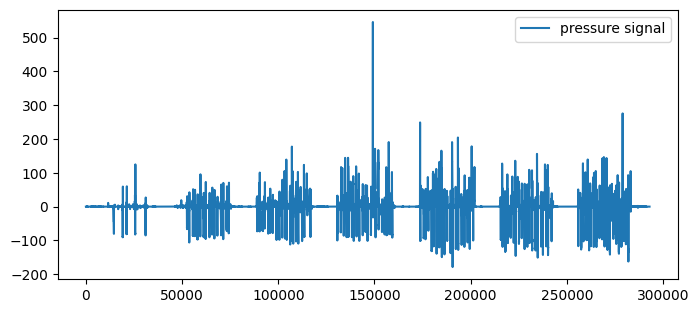

In [296]:
plt.figure(figsize=(8, 3.5))
plt.plot(PressureData_array_down, label='pressure signal')
plt.legend()

<a id='Import-Flow-data'></a>

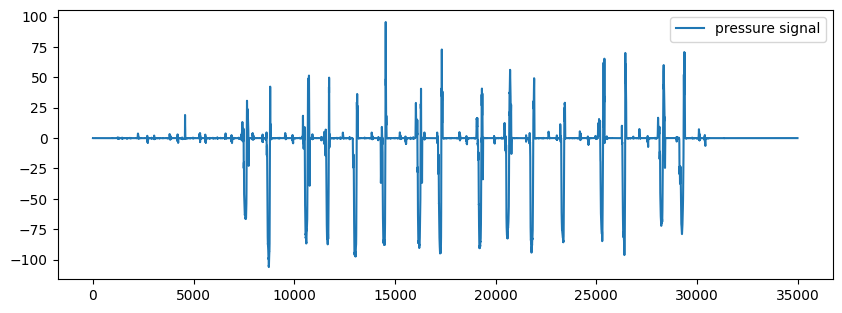

In [297]:
# closer inspection

%matplotlib inline

range_start = 45000
range_end = range_start + 35000

plt.figure(figsize=(10, 3.5))
plt.plot(PressureData_array_down[range_start:range_end], label='pressure signal')
plt.legend()

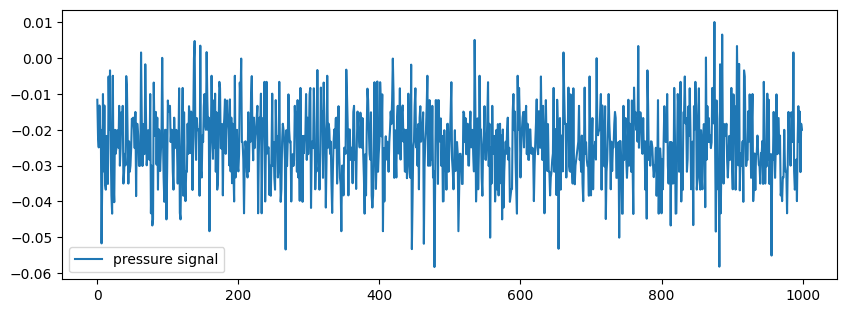

In [298]:
# closer inspection of baseline noise

%matplotlib inline

range_start = 45000
range_end = range_start + 1000

plt.figure(figsize=(10, 3.5))
plt.plot(PressureData_array_down[range_start:range_end], label='pressure signal: baseline noise')
plt.legend()

In [316]:
# Filtering the data
order = 1
fs = newSampleFrequencyPressure       # sample rate, Hz
cutoff = 5                          # desired cutoff frequency of the filter, Hz
T = len(PressureData_array_down)/fs
n = int(T * fs) # total number of samples

t = np.linspace(0, T, n, endpoint=False)


PressureData_array_down_filtered = butter_lowpass_filter(PressureData_array_down, cutoff, fs, order)

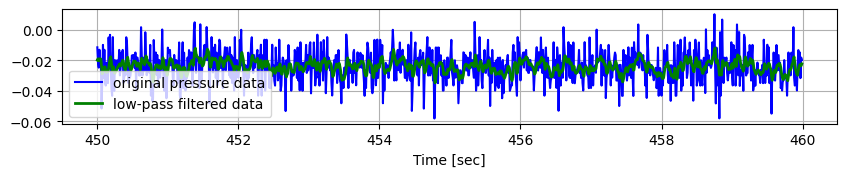

In [300]:

# closer inspection of baseline noise

plt.figure(figsize=(10, 3.5))
plt.subplot(2, 1, 2)
plt.plot(t[range_start:range_end], PressureData_array_down[range_start:range_end], 'b-', label='original pressure data')
plt.plot(t[range_start:range_end], PressureData_array_down_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

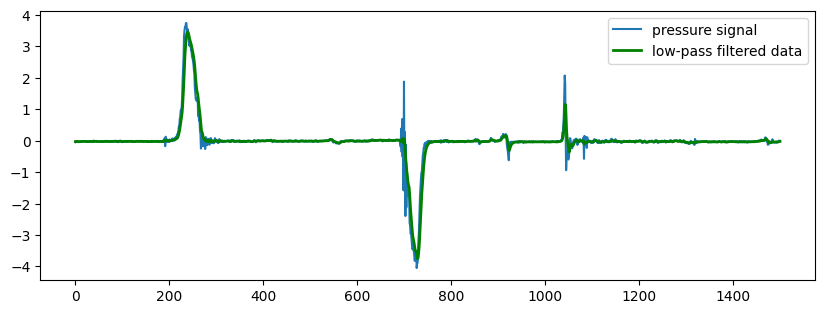

In [327]:
# closer inspection of small signal

%matplotlib inline

range_start = 47000
range_end = range_start + 1500

plt.figure(figsize=(10, 3.5))
plt.plot(PressureData_array_down[range_start:range_end], label='pressure signal')
plt.plot(PressureData_array_down_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.legend()

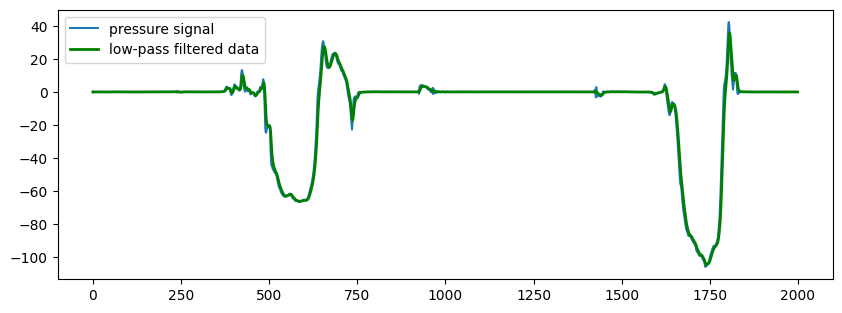

In [302]:
# closer inspection of large signal

%matplotlib inline

range_start = 52000
range_end = range_start + 2000

plt.figure(figsize=(10, 3.5))
plt.plot(PressureData_array_down[range_start:range_end], label='pressure signal')
plt.plot(PressureData_array_down_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.legend()

#### <mark style="background-color: #DAF7A6"> **Import Flow data:** </mark>

Importing flow data from the .edf file

[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [303]:
Flow_path_file = absolute_path + '*.edf'
Flow_files = glob.glob(Flow_path_file)

In [304]:
def getFlowData(edf_file):
    with open(edf_file) as fd:
        reader=csv.reader(fd)
        timeList = []
        flowList = []
        temperatureList = []
        print("Metadata of the device:")
        for idx, row in enumerate(reader):
            if idx < 10:
                print(row)
            if idx == 8:
                sMF = "Measurement_Frequency="
                sampleFrequencyPressure = float(row[8][len(sMF):sMF.find("Hz")-1])
                
            if idx >= 10:
                aDate = row[0].split()[1]
                timeIdx_colon = [x.start() for x in re.finditer('\:', aDate)]
                timeIdx_plus = [x.start() for x in re.finditer('\+', aDate)]
                minutes = float(aDate[timeIdx_colon[0]+1:timeIdx_colon[1]])
                seconds = float(aDate[timeIdx_colon[1]+1:timeIdx_plus[0]])
                total_seconds = minutes * 60 + seconds
                timeList.append(total_seconds)
                flowList.append(float(row[0].split()[2]))
                temperatureList.append(float(row[0].split()[3]))
    FlowData = pd.DataFrame({
                            "Time"          : np.array(timeList),
                            "Flow"          : np.array(flowList),
                            "Temperature"   : np.array(temperatureList)
                                })
    return FlowData, sampleFrequencyPressure


In [305]:
FlowData, sampleFrequencyFlow = getFlowData(Flow_files[0])
FlowData.head()

Metadata of the device:
['# EdfVersion=4.0']
['# Date=2021-06-02T15:22:16.271245+02:00']
['# ApplicationName=ControlCenter']
['# ApplicationVersion=1.27.0']
['# FilePath=C:/Users/stimuser/Desktop/VMP2/sub_0272\\2021-06-02_15-22-06-SFM3019_2033002283.edf']
['# HostName=ecg-stim1']
['# OperatingSystem=Windows-10-10.0.19041-SP0']
['# SensorId=2033002283']
['# Unit=s', 'Type=float64', 'Format=.3f\tType=string\tPort=1', 'Type=float', 'Gas_Mode=Air', 'Unit=slm', 'SensorName=SFM3019', 'Product=SFM3019', 'Measurement_Frequency=100.0Hz', 'Sensor_Serial_Number=2033002283', 'Device_Serial_Number=EKS2-52002B000851383138393139', 'Signal=Flow', 'Device=687f1a04\tPort=1', 'Type=float', 'Unit=°C', 'SensorName=SFM3019', 'Product=SFM3019', 'Measurement_Frequency=100.0Hz', 'Sensor_Serial_Number=2033002283', 'Device_Serial_Number=EKS2-52002B000851383138393139', 'Signal=Temperature', 'Device=687f1a04']
['Epoch_UTC\tLocal_Date_Time\tF_SFM3019_2033002283\tT_SFM3019_2033002283']


,Time,Flow,Temperature
0,1326.307,0.000000,23.975
1,1326.317,-0.017647,23.975
2,1326.327,-0.005882,23.990
3,1326.339,-0.005882,23.970
4,1326.349,-0.005882,24.120


#### Summary:

- `Signal=Flow`, 
- `SensorName=SFM3019`, 
- [Device page](https://sensirion.com/products/catalog/SFM3019/)

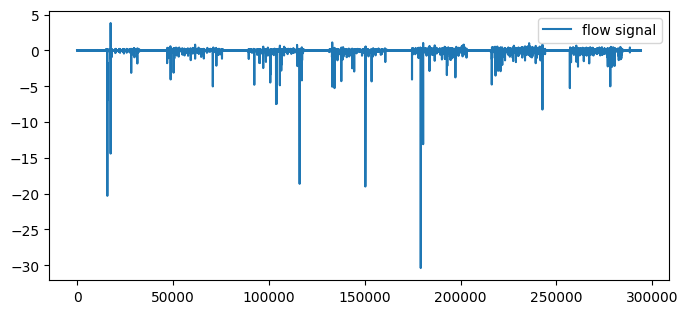

In [306]:
FlowData_array          = FlowData["Flow"].to_numpy()
FlowTemperature_array   = FlowData["Temperature"].to_numpy()
FlowTime_array          = FlowData["Time"].to_numpy()

plt.figure(figsize=(8, 3.5))
plt.plot(FlowData_array, label='flow signal')
plt.legend()

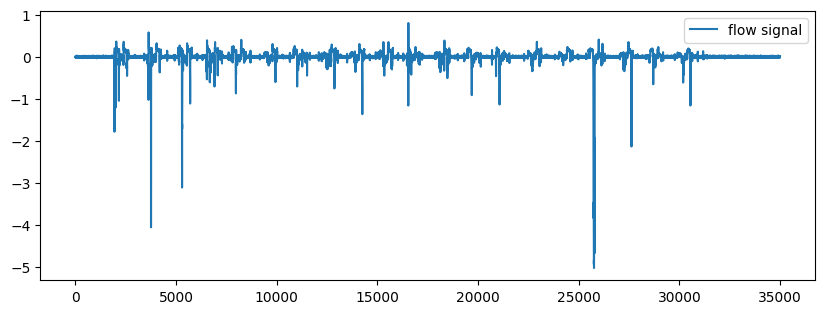

In [307]:
# closer inspection

%matplotlib inline

range_start = 45000
range_end = range_start + 35000

plt.figure(figsize=(10, 3.5))
plt.plot(FlowData_array[range_start:range_end], label='flow signal')
plt.legend()

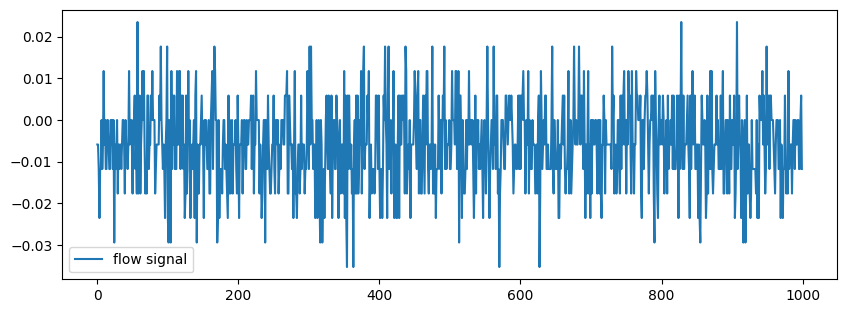

In [308]:
# closer inspection at noise

%matplotlib inline

range_start = 45000
range_end = range_start + 1000

plt.figure(figsize=(10, 3.5))
plt.plot(FlowData_array[range_start:range_end], label='flow signal: baseline noise')
plt.legend()

In [313]:
# Filtering the data
order = 1
fs = sampleFrequencyFlow       # sample rate, Hz
cutoff = 5                          # desired cutoff frequency of the filter, Hz
T = len(FlowData_array)/fs
n = int(T * fs) # total number of samples

t = np.linspace(0, T, n, endpoint=False)


FlowData_array_filtered = butter_lowpass_filter(FlowData_array, cutoff, fs, order)

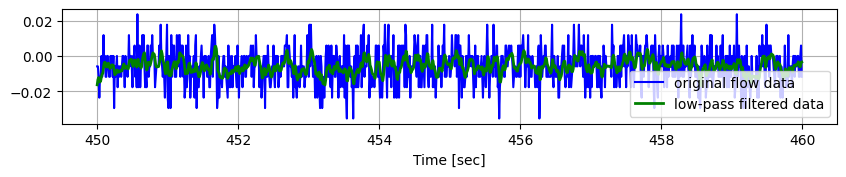

In [310]:
# Filter the data, and plot both the original and filtered signals.

plt.figure(figsize=(10, 3.5))
plt.subplot(2, 1, 2)
plt.plot(t[range_start:range_end], FlowData_array[range_start:range_end], 'b-', label='original flow data')
plt.plot(t[range_start:range_end], FlowData_array_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

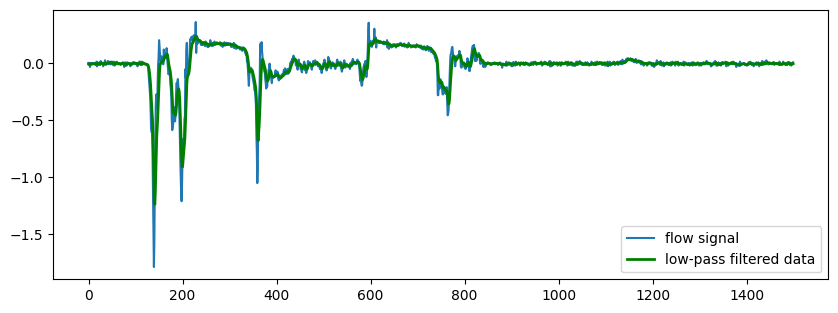

In [311]:
# closer inspection at small signal

%matplotlib inline

range_start = 46800
range_end = range_start + 1500

plt.figure(figsize=(10, 3.5))
plt.plot(FlowData_array[range_start:range_end], label='flow signal')
plt.plot(FlowData_array_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.legend()

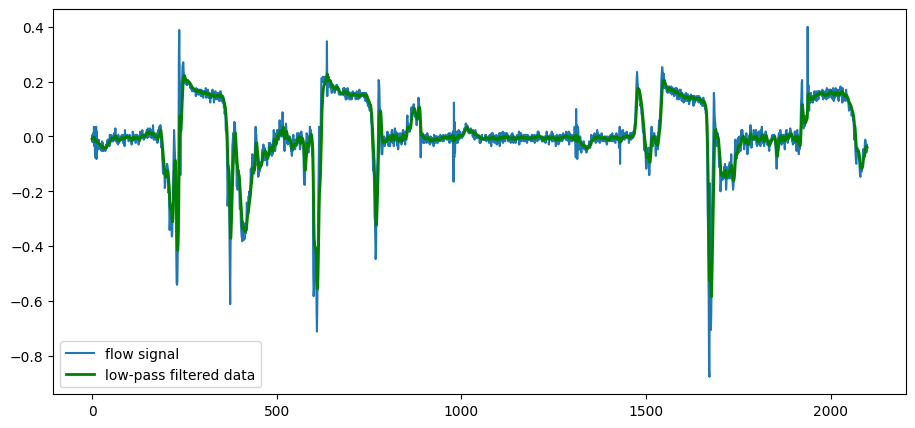

In [324]:
# closer inspection at the interval corresponding to the observed large pressure signal

%matplotlib inline

range_start = 51300
range_end = range_start + 2100

plt.figure(figsize=(11, 5))
plt.plot(FlowData_array[range_start:range_end], label='flow signal')
plt.plot(FlowData_array_filtered[range_start:range_end], 'g-', linewidth=2, label='low-pass filtered data')
plt.legend()

<a id='Aligning-flow-and-pressure-data-with-the-behavioral-data'></a>

#### <mark style="background-color: #DAF7A6"> **Aligning flow and pressure data with the behavioral data:** </mark>


[Return to the table of contents.](#exploratory-analysis-of-the-rrst-pressure-and-flow-project)


In [258]:
# photodiode data demeaned and downsampled
PhotodiodeData_dm_down = downSampling(data_dm)                      
# downsampled impedance value from the respiration belt
RespirationData_down = downSampling(RespirationData_origLength)     
# PressureData_array_down_filtered                      # downsampled pressure signal
# PressureTemperature_array_down                        # downsampled temperature signal from the pressure device
# PressureTime_array_down                               # downsampled time stamp from the pressure device
# FlowData_array_filtered                               # flow signal
# FlowTemperature_array                                 # temperature signal from the flow device
# FlowTime_array                                        # time stamp from the flow device

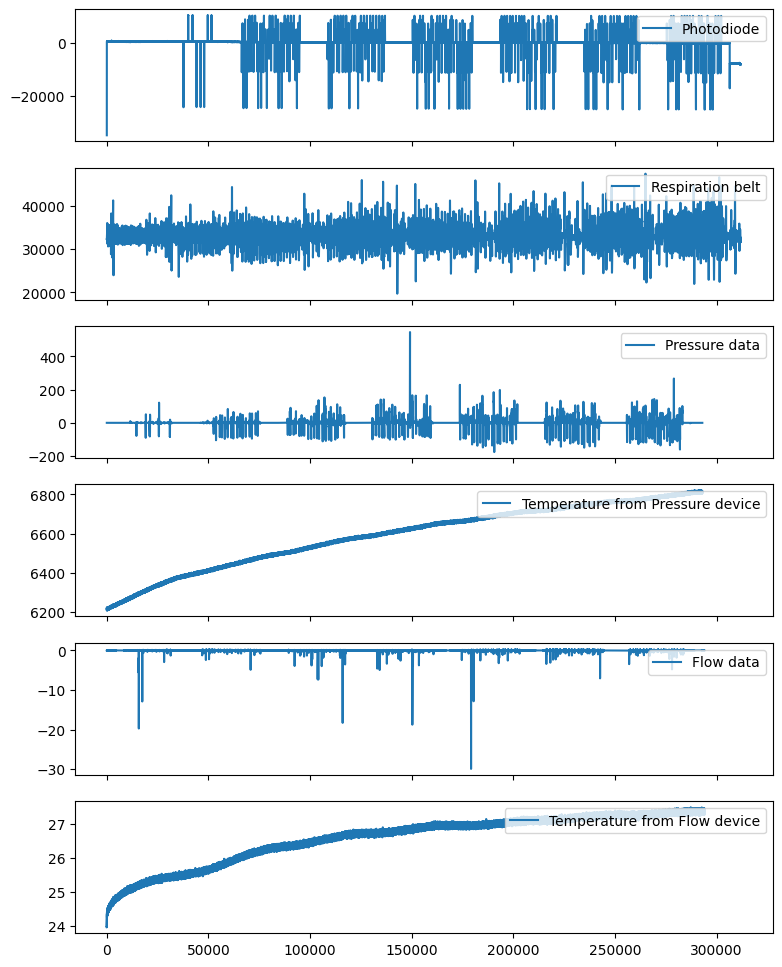

In [317]:

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True)
f.set_figheight(12)
f.set_figwidth(9)

ax1.plot(PhotodiodeData_dm_down, label='Photodiode')
ax1.legend(["Photodiode"],loc='upper right')

ax2.plot(RespirationData_down, label='Respiration belt')
ax2.legend(["Respiration belt"],loc='upper right')

ax3.plot(PressureData_array_down_filtered, label='Pressure data')
ax3.legend(["Pressure data"],loc='upper right')

ax4.plot(PressureTemperature_array_down, label='Temperature from Pressure device')
ax4.legend(["Temperature from Pressure device"],loc='upper right')

ax5.plot(FlowData_array_filtered, label='Flow data')
ax5.legend(["Flow data"],loc='upper right')

ax6.plot(FlowTemperature_array, label='Temperature from Flow device')
ax6.legend(["Temperature from Flow device"],loc='upper right')

plt.show()

In [318]:
%matplotlib tk

rangeToVisualize_start = 30000
rangeToVisualize_end = rangeToVisualize_start + 100000

f, (ax1, ax2, ax3, ax5) = plt.subplots(4, sharex=True)
f.set_figheight(12)
f.set_figwidth(12)

ax1.plot(PhotodiodeData_dm_down[rangeToVisualize_start:rangeToVisualize_end], label='Photodiode')
ax1.legend(["Photodiode"],loc='upper right')

ax2.plot(RespirationData_down[rangeToVisualize_start:rangeToVisualize_end], label='Respiration belt')
ax2.legend(["Respiration belt"],loc='upper right')

ax3.plot(PressureData_array_down_filtered[rangeToVisualize_start:rangeToVisualize_end], label='Pressure data')
ax3.legend(["Pressure data"],loc='upper right')

ax5.plot(FlowData_array_filtered[rangeToVisualize_start:rangeToVisualize_end], label='Flow data')
ax5.legend(["Flow data"],loc='upper right')


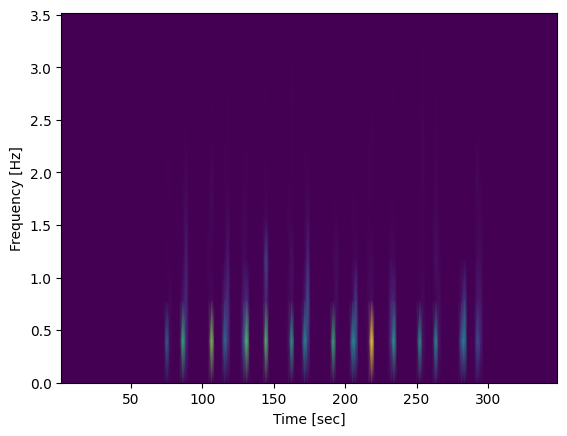

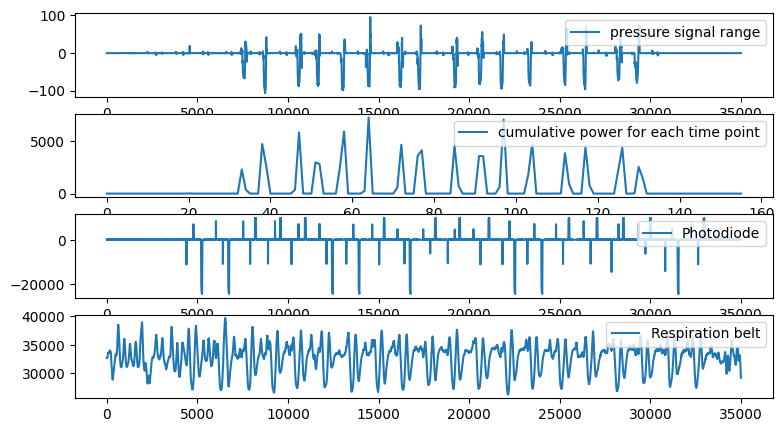

In [358]:
# spectrogram
%matplotlib inline

range_start = 45000
range_end = range_start + 35000

maxFIdx = 10
f, t, Sxx = signal.spectrogram(PressureData_array_down[range_start:range_end], fs)

plt.pcolormesh(t, f[:maxFIdx], Sxx[:maxFIdx], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

%matplotlib tk

f, (ax1, ax2, ax3, ax4) = plt.subplots(4)
f.set_figheight(5)
f.set_figwidth(9)

range_start = 45000
range_end = range_start + 35000

ax1.plot(PressureData_array_down[range_start:range_end])
ax1.legend(["pressure signal range"],loc='upper right')

ax2.plot(sum(Sxx))
ax2.legend(["cumulative power for each time point"],loc='upper right')

photoResp_shift = 17000

ax3.plot(PhotodiodeData_dm_down[photoResp_shift+range_start:photoResp_shift+range_end], label='Photodiode')
ax3.legend(["Photodiode"],loc='upper right')

ax4.plot(RespirationData_down[photoResp_shift+range_start:photoResp_shift+range_end], label='Respiration belt')
ax4.legend(["Respiration belt"],loc='upper right')

plt.show()
%matplotlib inline

In [369]:
subSxx = Sxx[:50]
print(len(subSxx[0]))
print(np.sum(subSxx).size)

print(np.sum(subSxx, axis = 0))

156
1
[1.18247238e-04 1.11302309e-04 1.05498819e-04 1.04791897e-04
 1.38548157e-04 2.67868240e-02 7.57788409e-03 2.33741012e-03
 4.11857788e-03 2.40596743e+00 1.72777850e-01 1.07979158e-01
 2.61327585e+00 1.48414073e-01 1.11138546e-03 1.57334965e-03
 1.67535705e+00 2.86577279e-01 2.17617831e+00 2.69029700e-01
 2.20738450e+01 1.48344021e-03 9.49023586e-03 2.22734627e+00
 1.97093773e+00 1.87661824e-01 3.49242723e-03 1.25769210e-02
 5.04411202e-03 2.55287977e+00 2.76231565e+00 9.30018756e-04
 1.92009269e+00 2.30634593e+03 3.56352277e+02 2.66509735e+00
 3.80546947e-04 5.79767720e-01 4.71816636e+03 2.55327775e+03
 2.07556421e-03 1.76229125e-03 3.01086658e+00 3.90708256e-04
 2.83347325e+00 3.85773705e-03 3.65281577e+02 5.82154704e+03
 8.73882983e+00 3.27734790e-04 6.92497620e-02 2.96746717e+03
 2.81015477e+03 1.68757695e-03 5.07826985e-03 3.55366253e+00
 2.71231850e-02 2.54378367e+03 5.90906837e+03 6.09260294e-04
 1.00440272e-02 3.46287503e+00 1.31466785e-03 2.49941065e+02
 7.23841489e+03 8.